In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "arc2_partial_max.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superkingplus/
Found 1 parquet files in datasets/superkingplus/
Loading superking dataset...


In [4]:
# Keep only refined examples.
from llm_python.datasets.query import filter_soar_df


df = superking_df.copy()
df = filter_soar_df(
    df,
    exclude_subset="arc-prize-2025/evaluation",
    any_train_correct=True,
    exclude_transductive=True
)


In [5]:
df = df[df["refined_from_id"].isna()]
df.drop(columns=["reasoning"], inplace=True)

In [6]:
# Deduplicate df by task_id and code
initial_len = len(df)
df = (
    df.drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 359620 (removed 85738)


In [ ]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "row_id"],
    sort_ascending=[False, False, False],
    task_limit=60,
)

In [8]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=PARQUET_SCHEMA)
print("Done.")

Saving final dataset to: /home/lewis/code/trelis-arc/arc2_partial_max.parquet
Done.


DATASET STATISTICS ANALYSIS: arc2_partial_max
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 932
   • Total programs: 55,391
   • Fully correct programs: 37,494 (67.7%)
   • Partially correct programs: 17,897 (32.3%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 0.817

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 59.4
   • Median programs per task: 75.0
   • Min programs per task: 1
   • Max programs per task: 75
   • Tasks with 75 programs (max): 641
   • Tasks with fully correct programs: 738
   • Tasks with no correct programs: 194

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 47.75
   • 50th percentile (median): 75.0
   • 75th percentile: 75.0
   • 90th percentile: 75.0
   • 95th percentile: 75.0
   • 99th percentile: 75.0
   • 100th percentile (max): 75.0

4. Creating 

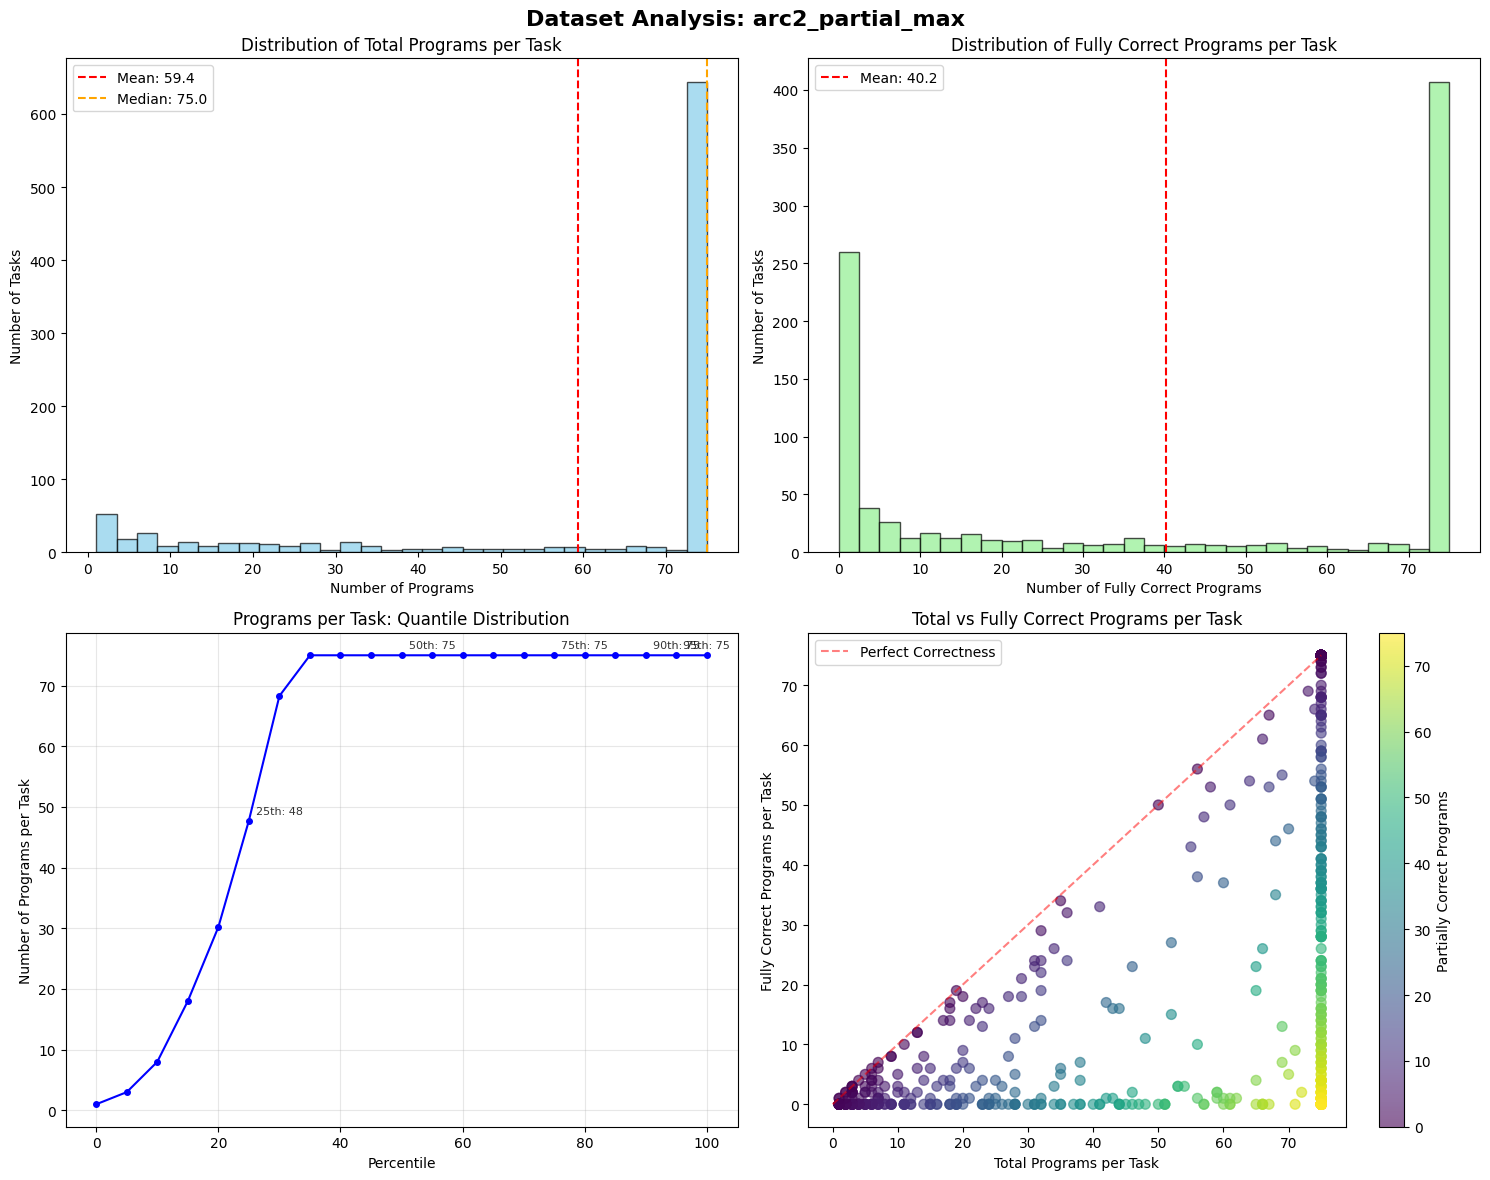


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [9]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, output_path.parts[-1].replace(".parquet", ""))